In [1]:
# FILENAMES real recording in sparcs
names = [
    'ACW50_0_0',
    'ACW50_0_5',
    'ACW50_0_10',
    'ACW50_0_15',
    'ACW50_30_0',
    'ACW50_30_5',
    'ACW50_30_10',
    'ACW50_30_15',
    'CW50_0_0',
    'CW50_0_5',
    'CW50_0_10',
    'CW50_0_15',
    'CW50_30_0',
    'CW50_30_5',
    'CW50_30_10',
    'CW50_30_15'
]

#NOTES: 
# -CW50_0_0 is only one lap

ACW50_0_0
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


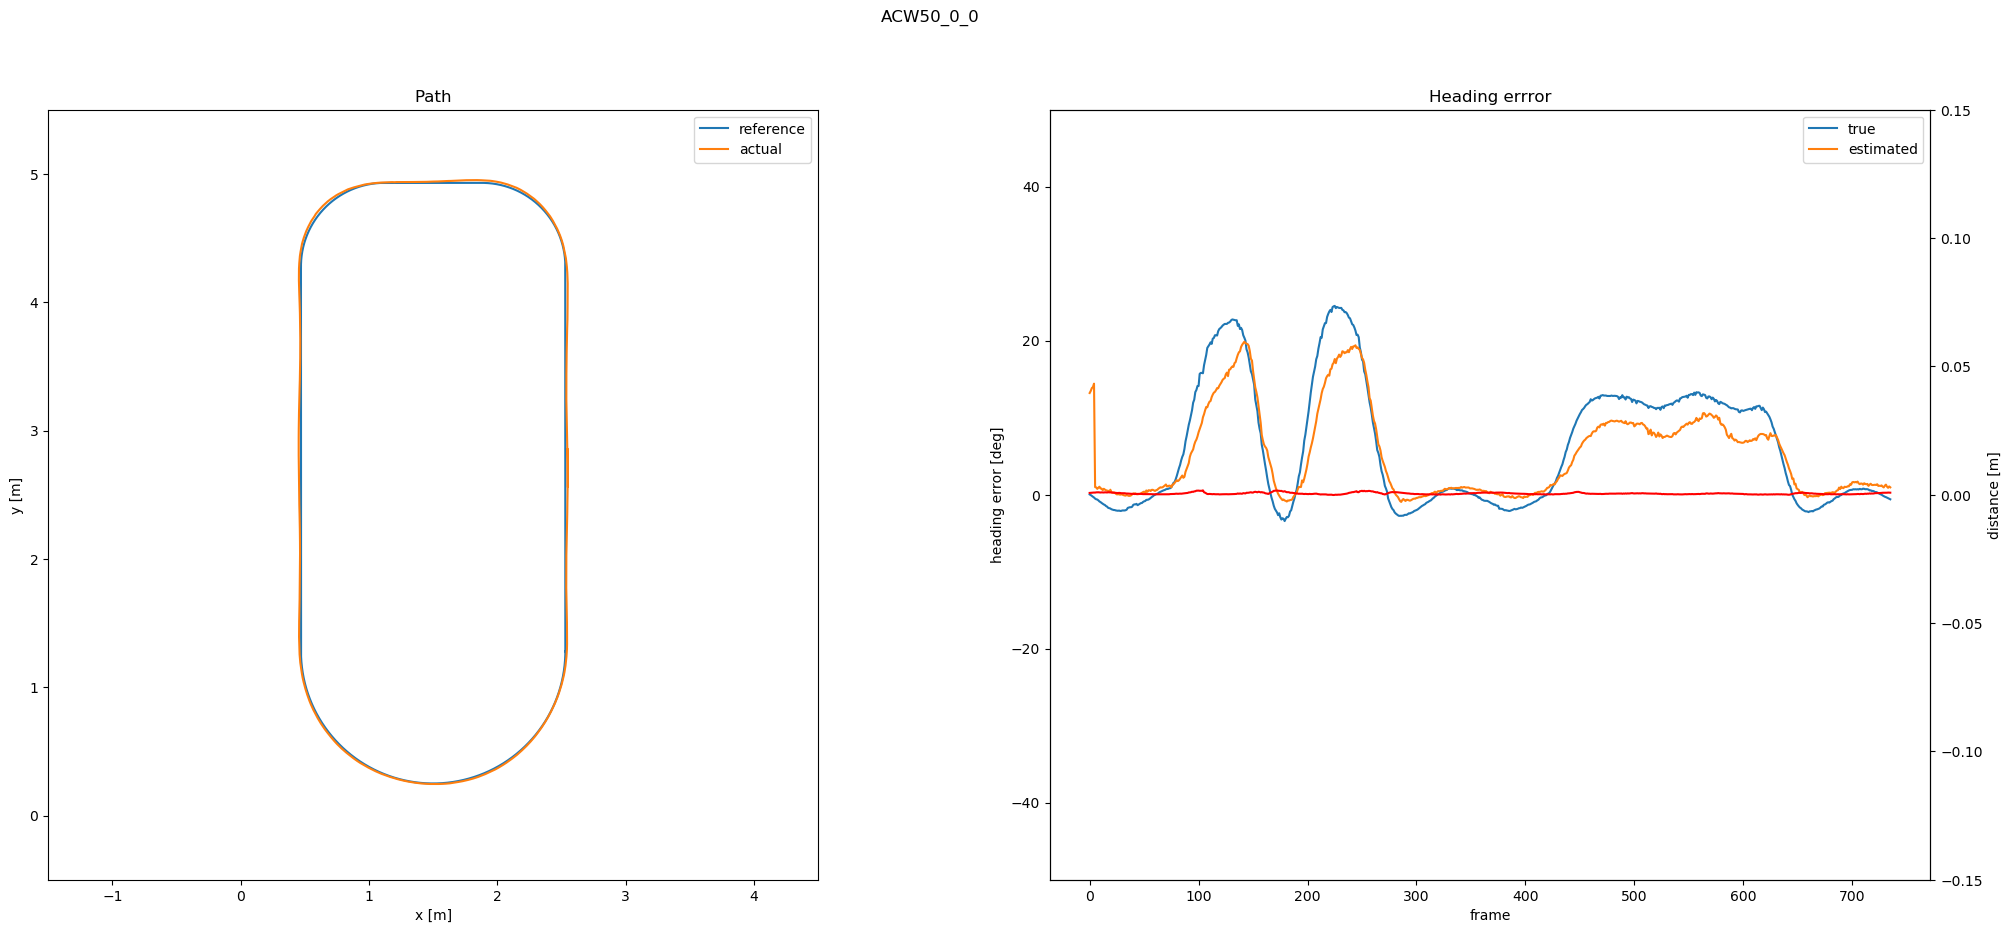

 
ACW50_0_5
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


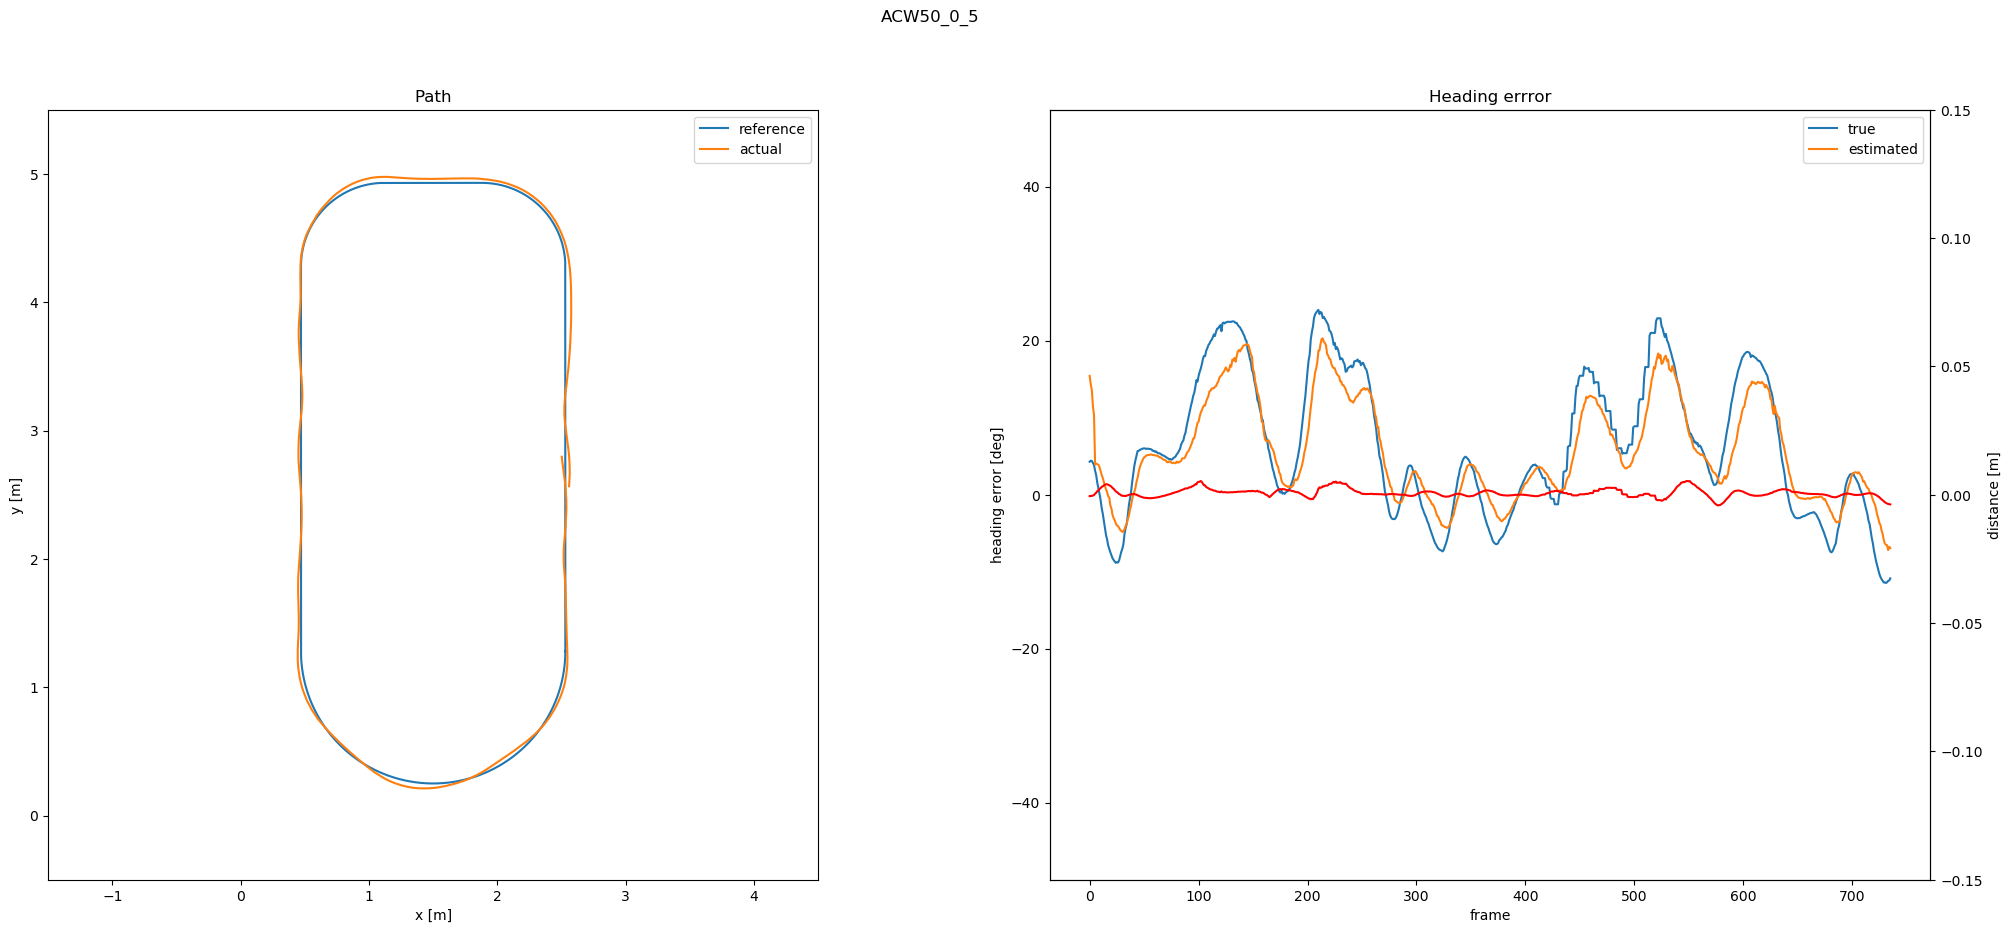

 
ACW50_0_10
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


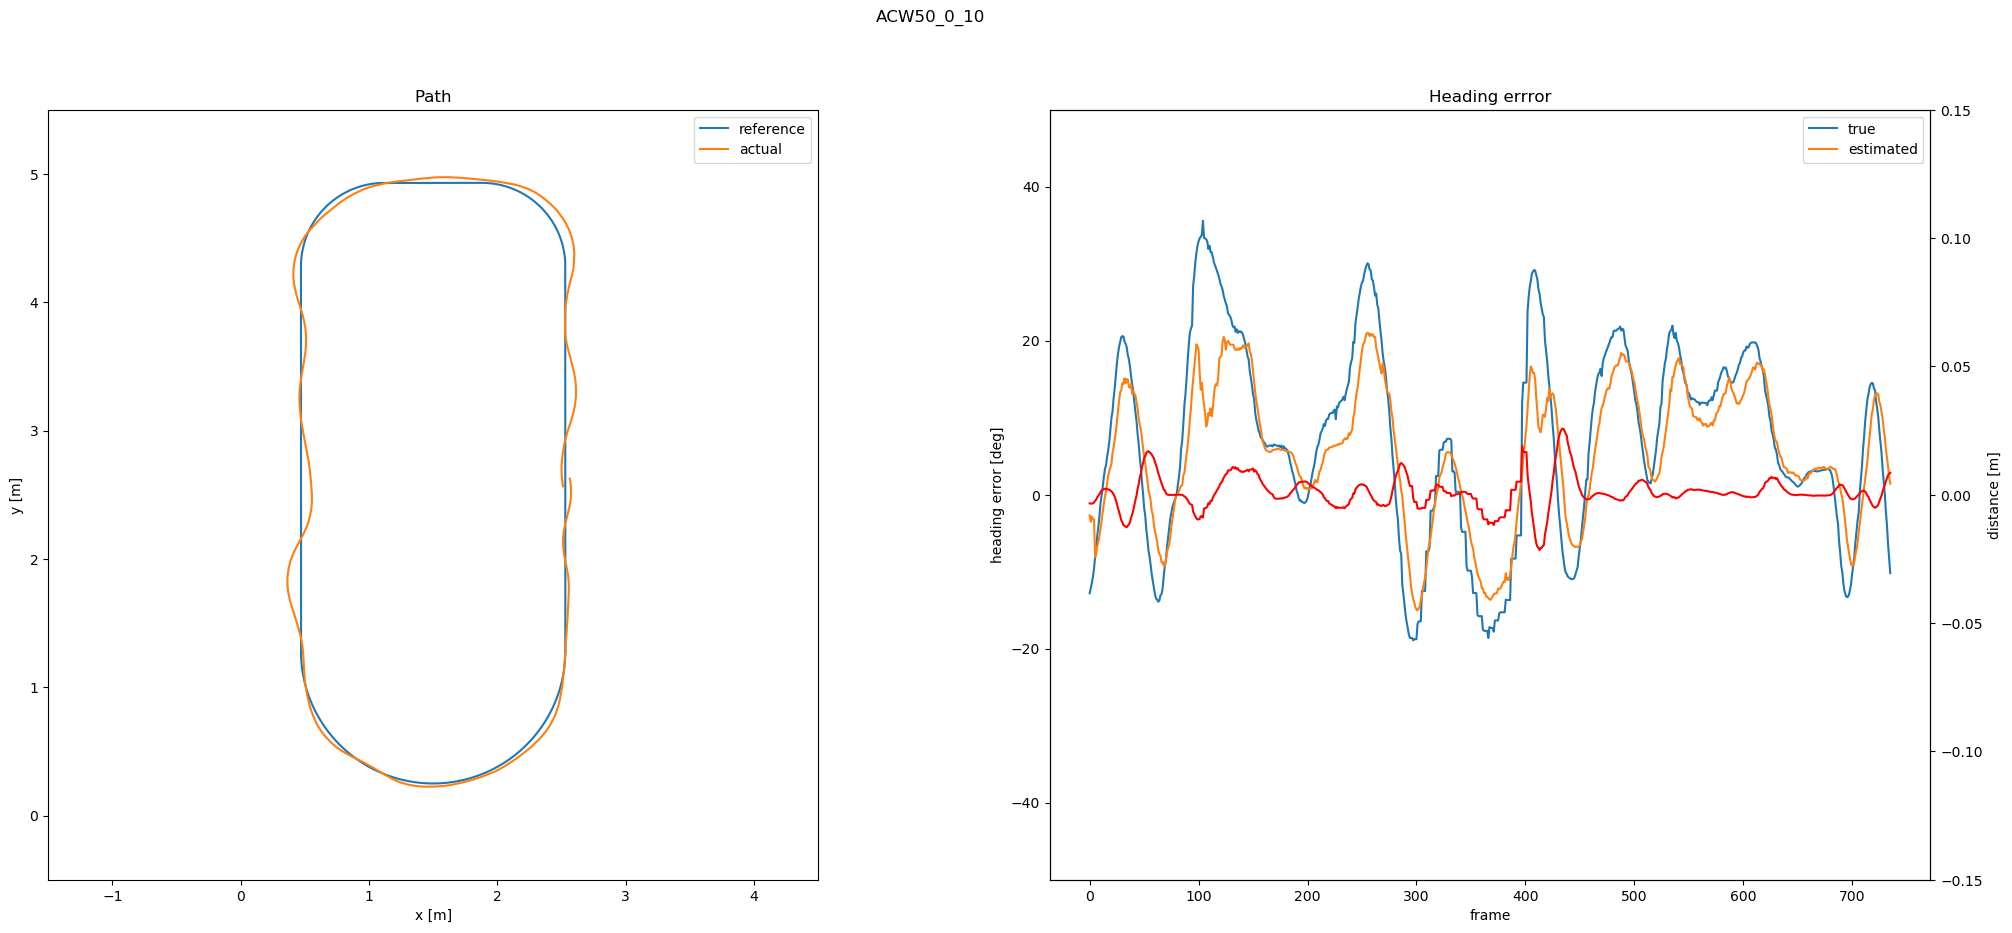

 
ACW50_0_15
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


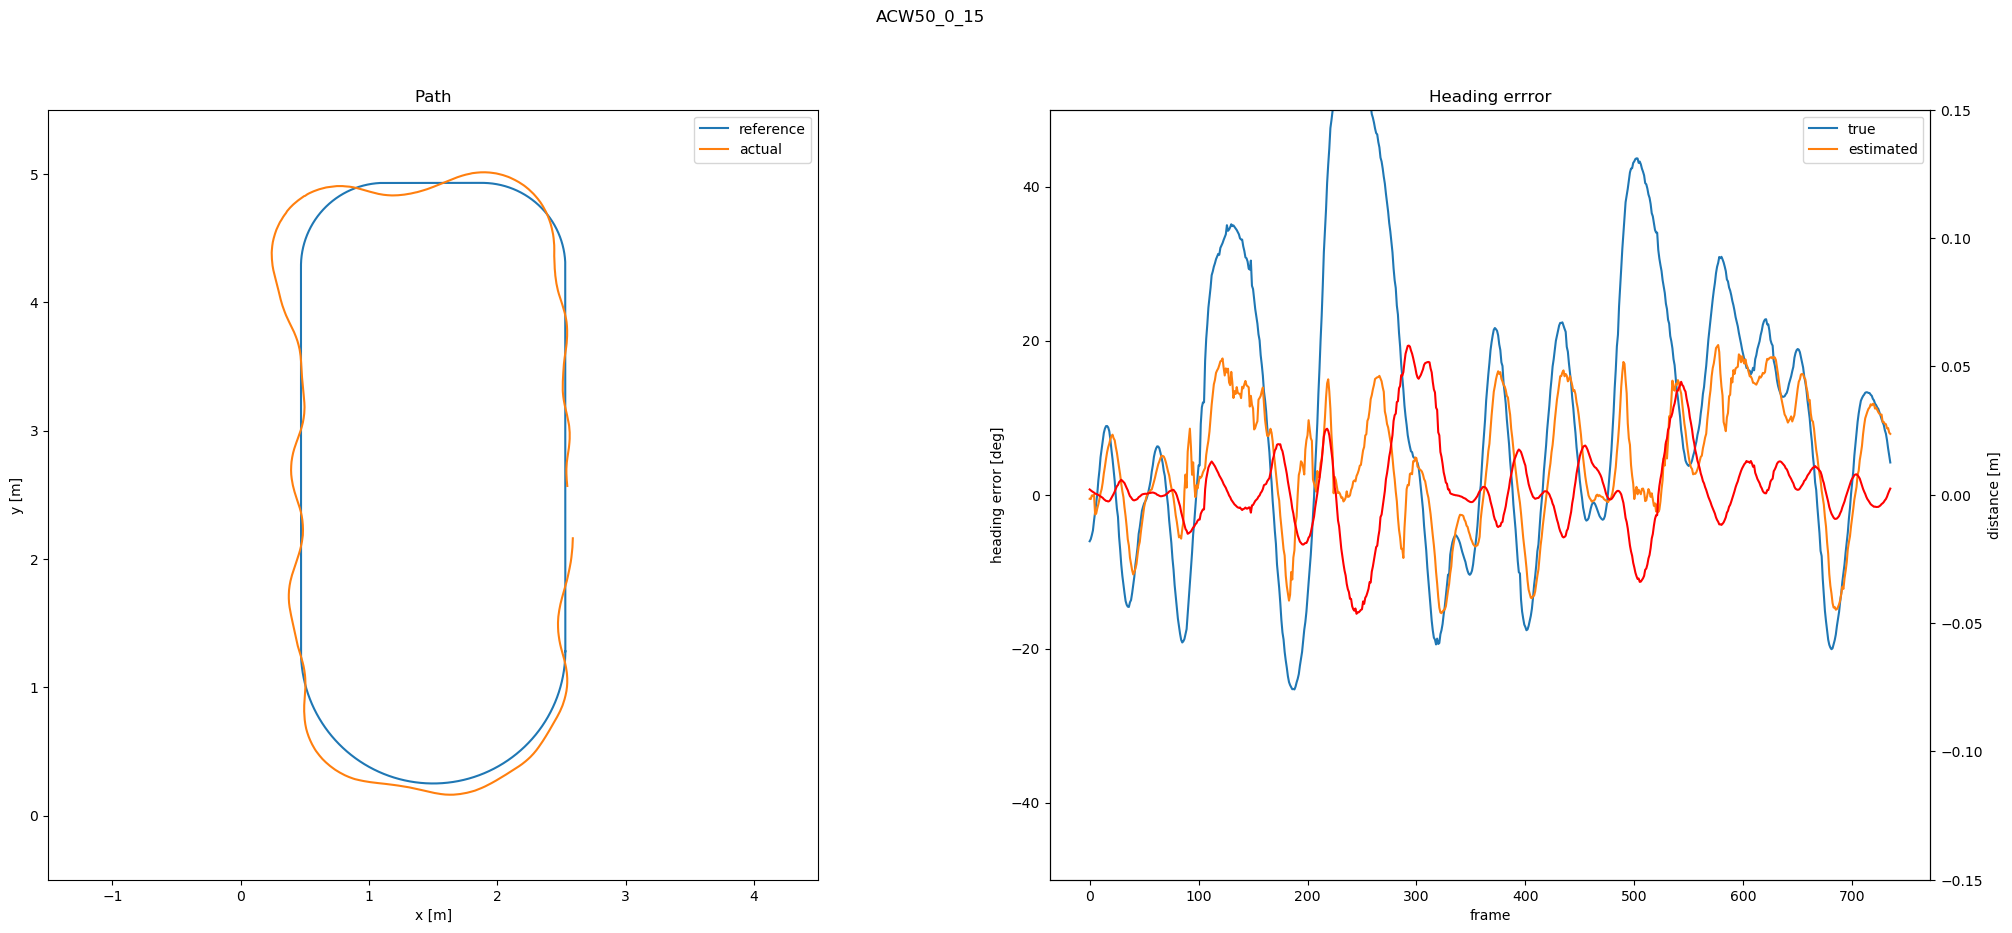

 
ACW50_30_0
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


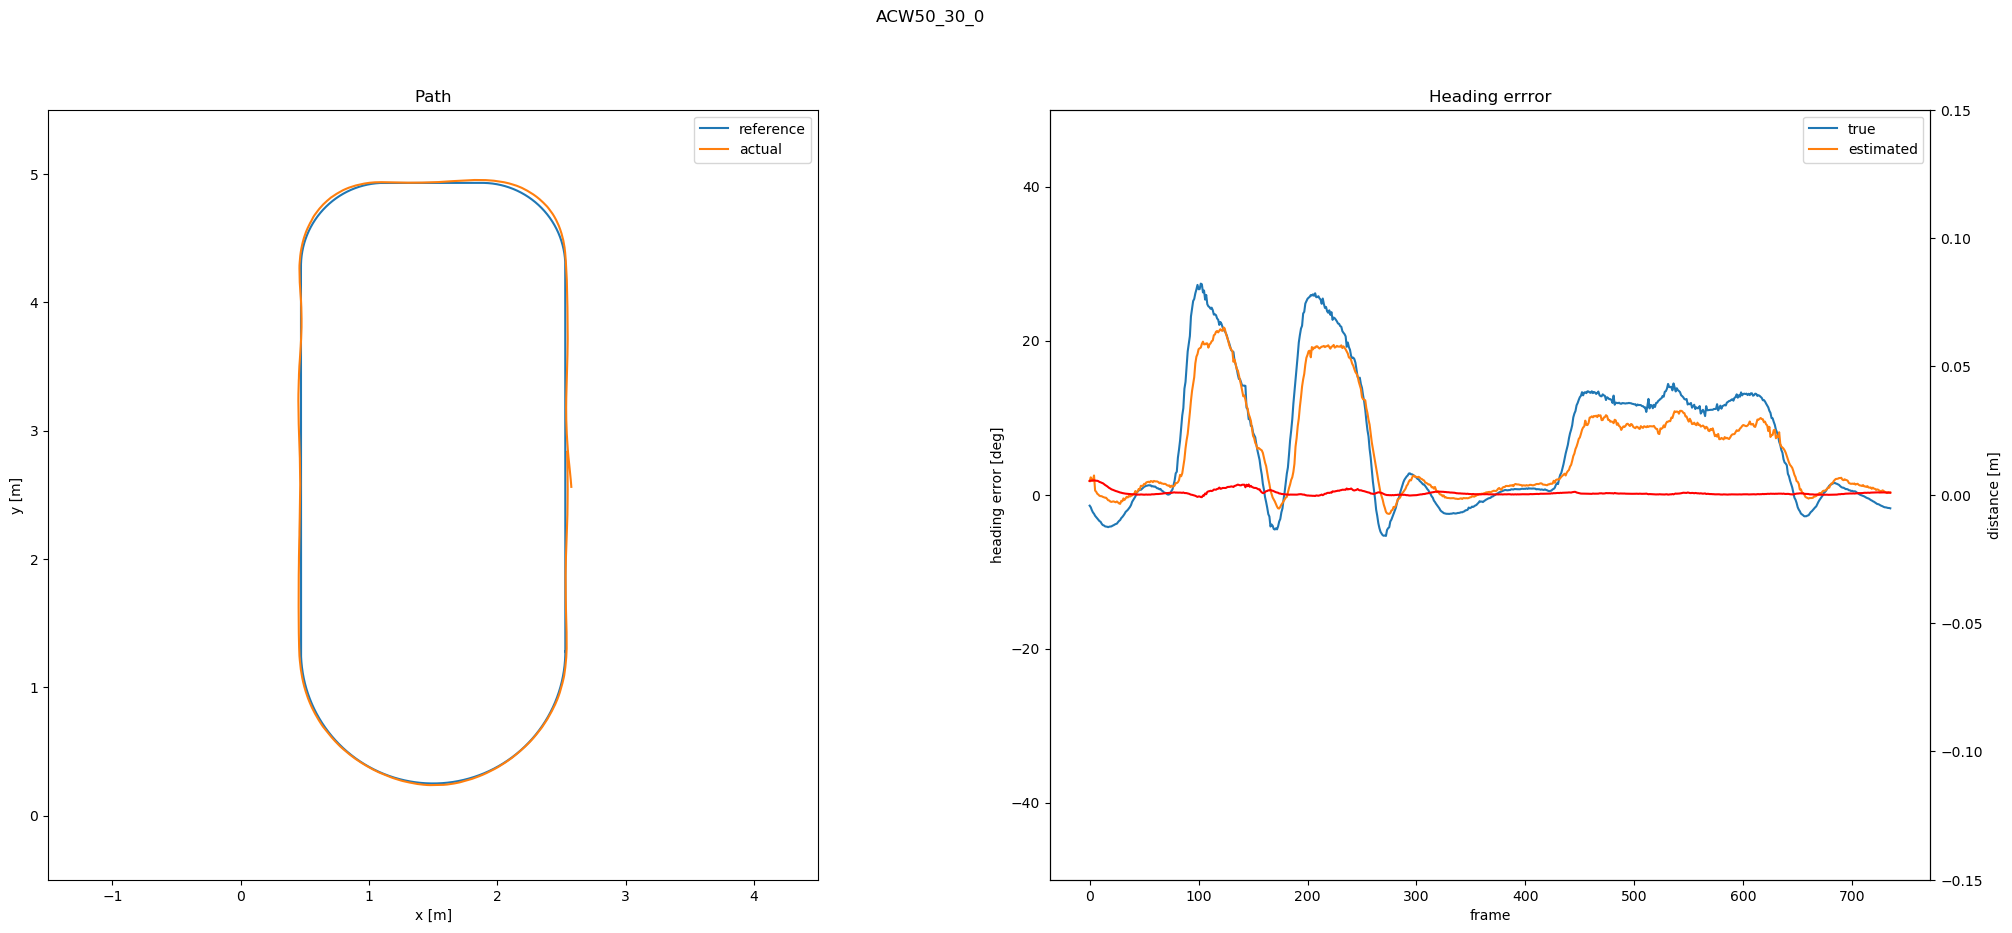

 
ACW50_30_5
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


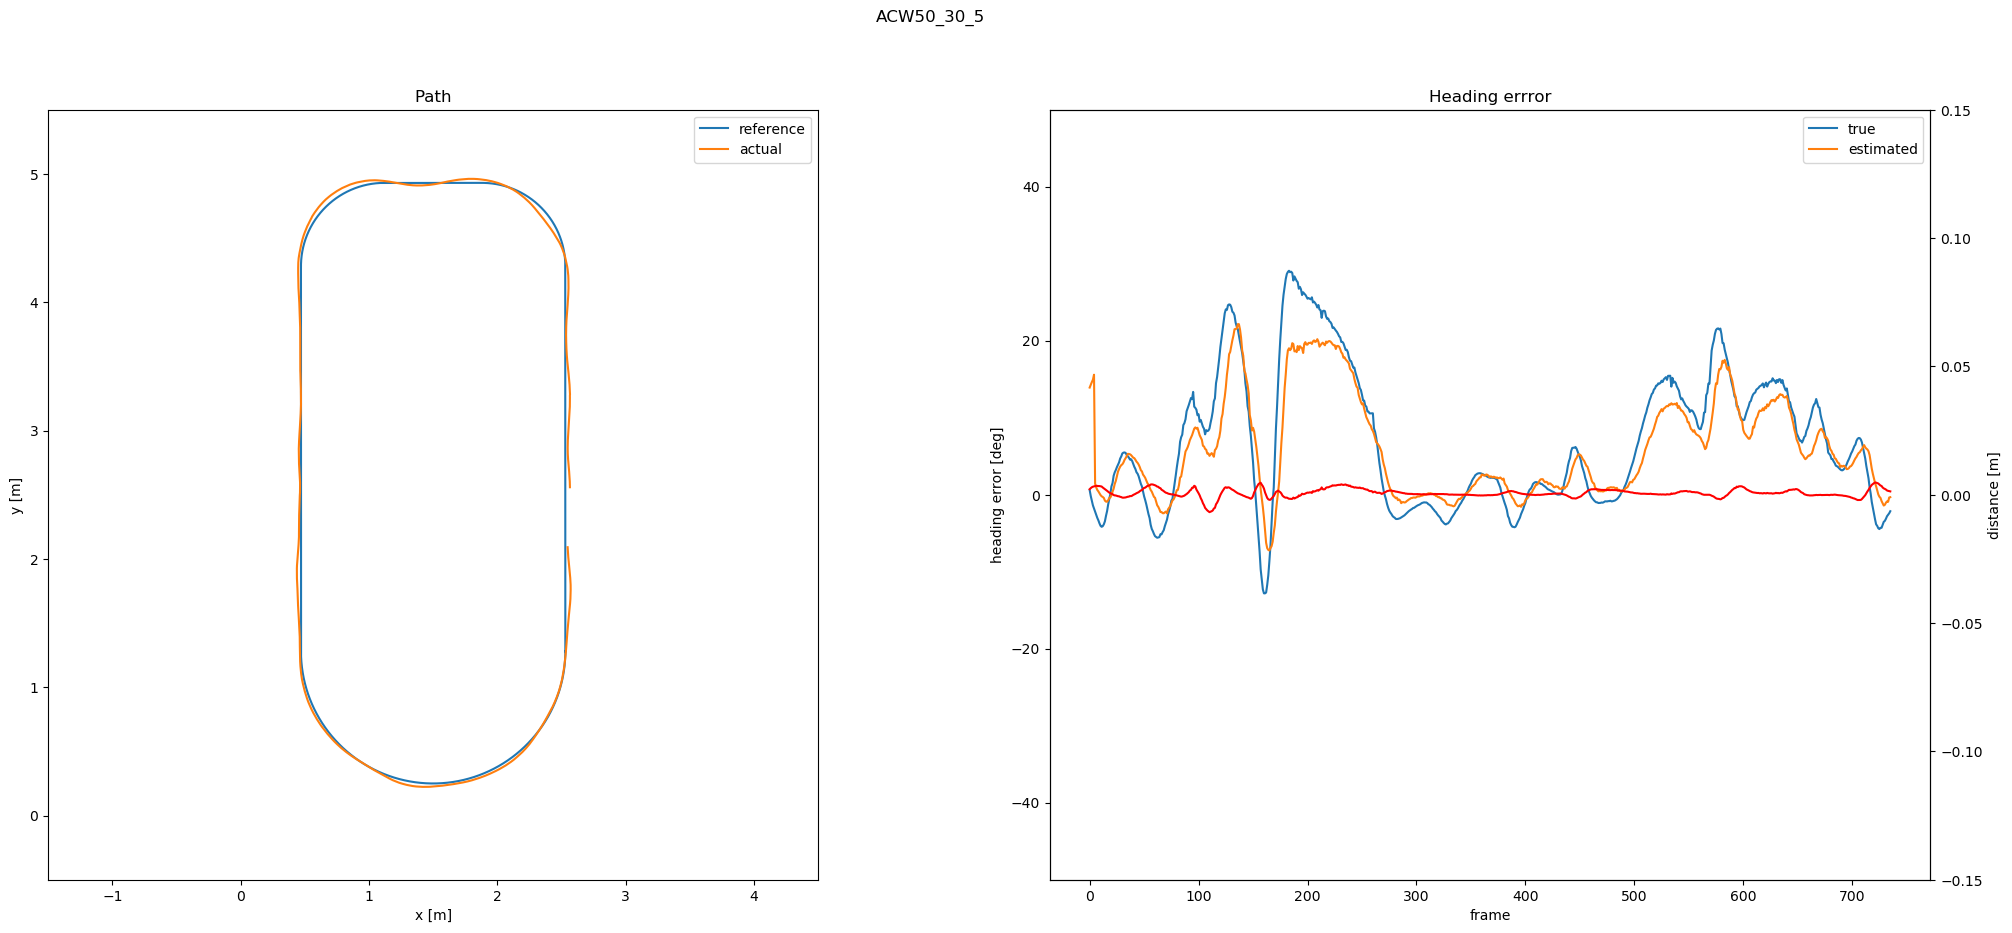

 
ACW50_30_10
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


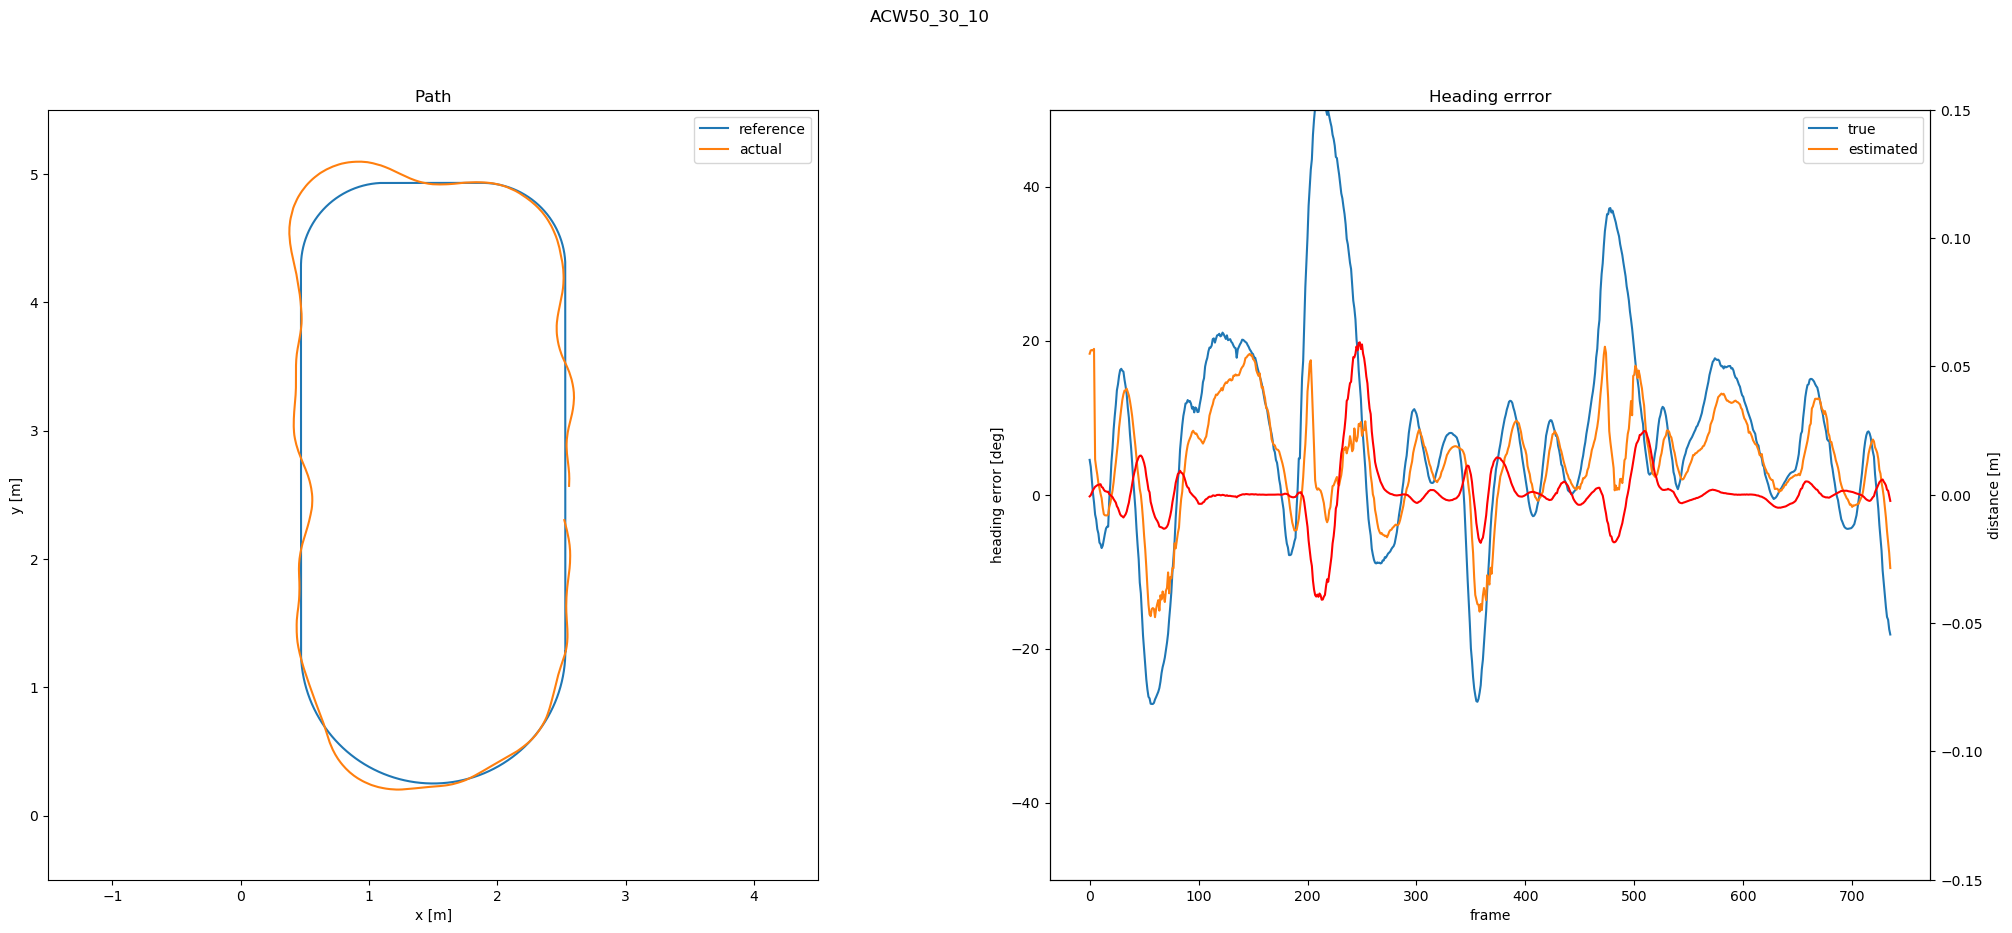

 
ACW50_30_15
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


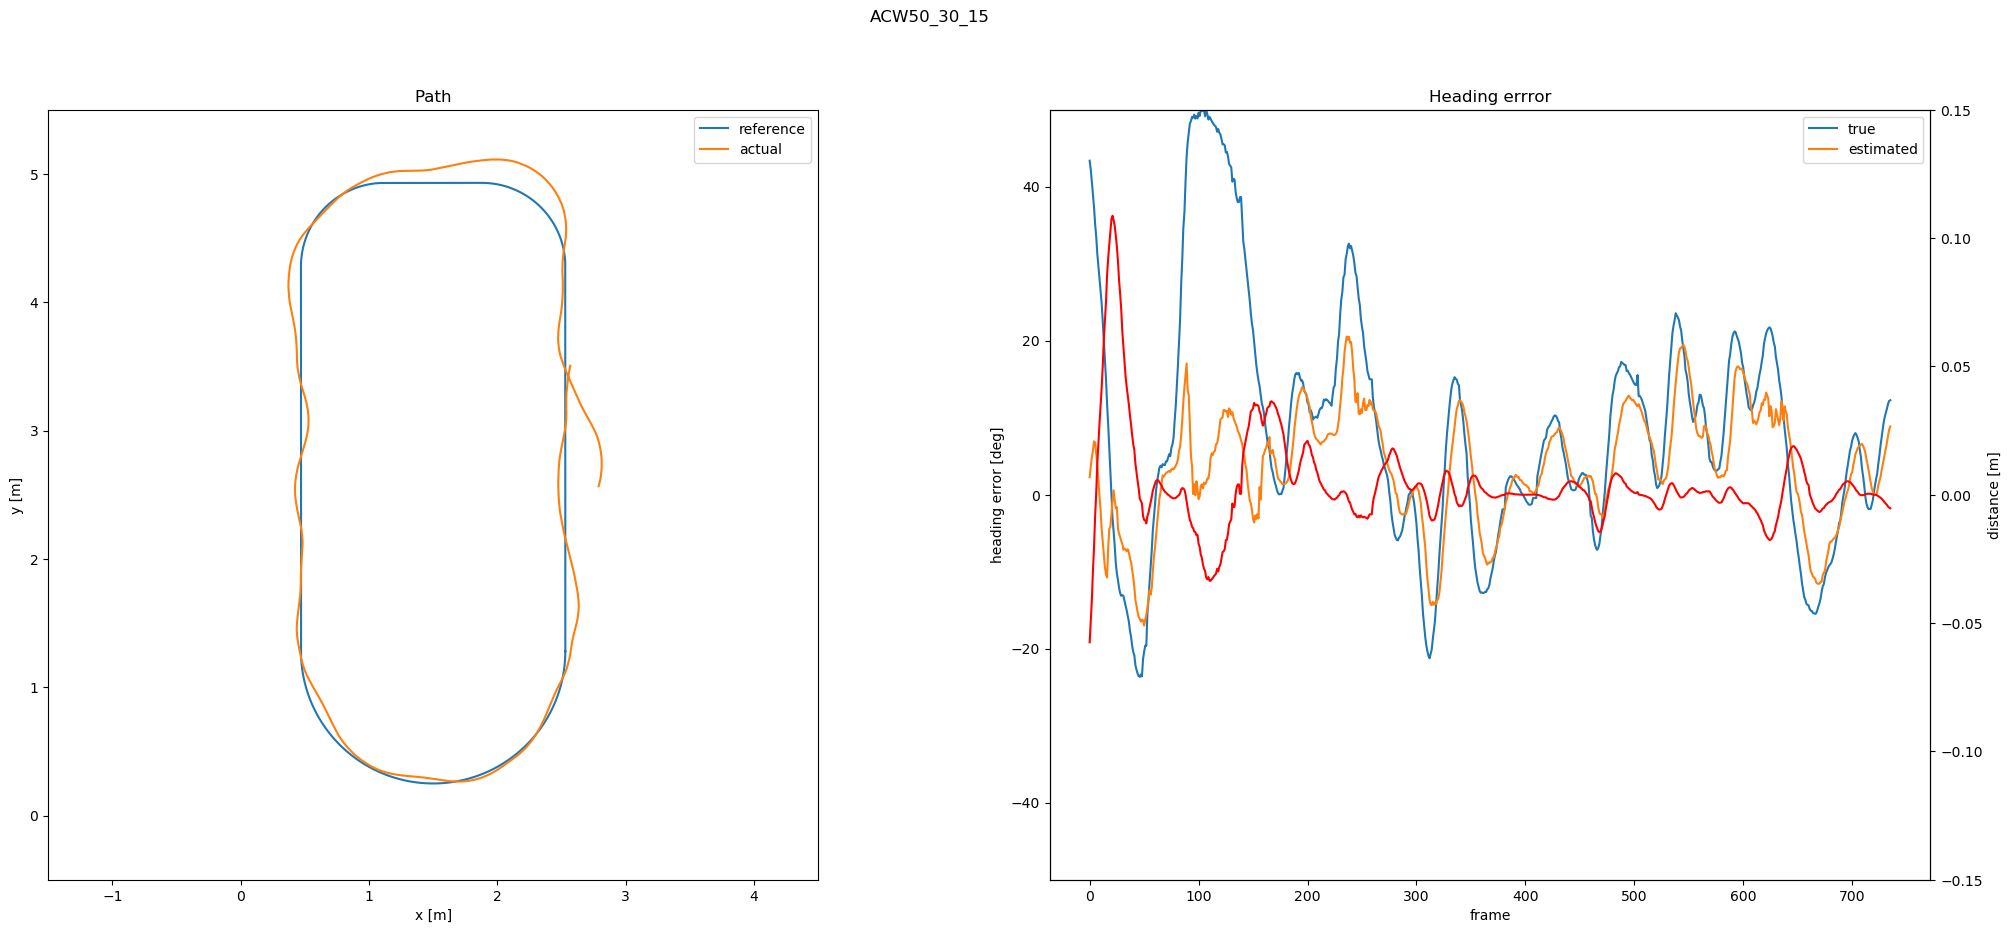

 
CW50_0_0
frames: 712, locs: 712
frame dim (240, 320), locs dim (3,)
we are too far from the path, min_dist: 0.3725000007290521


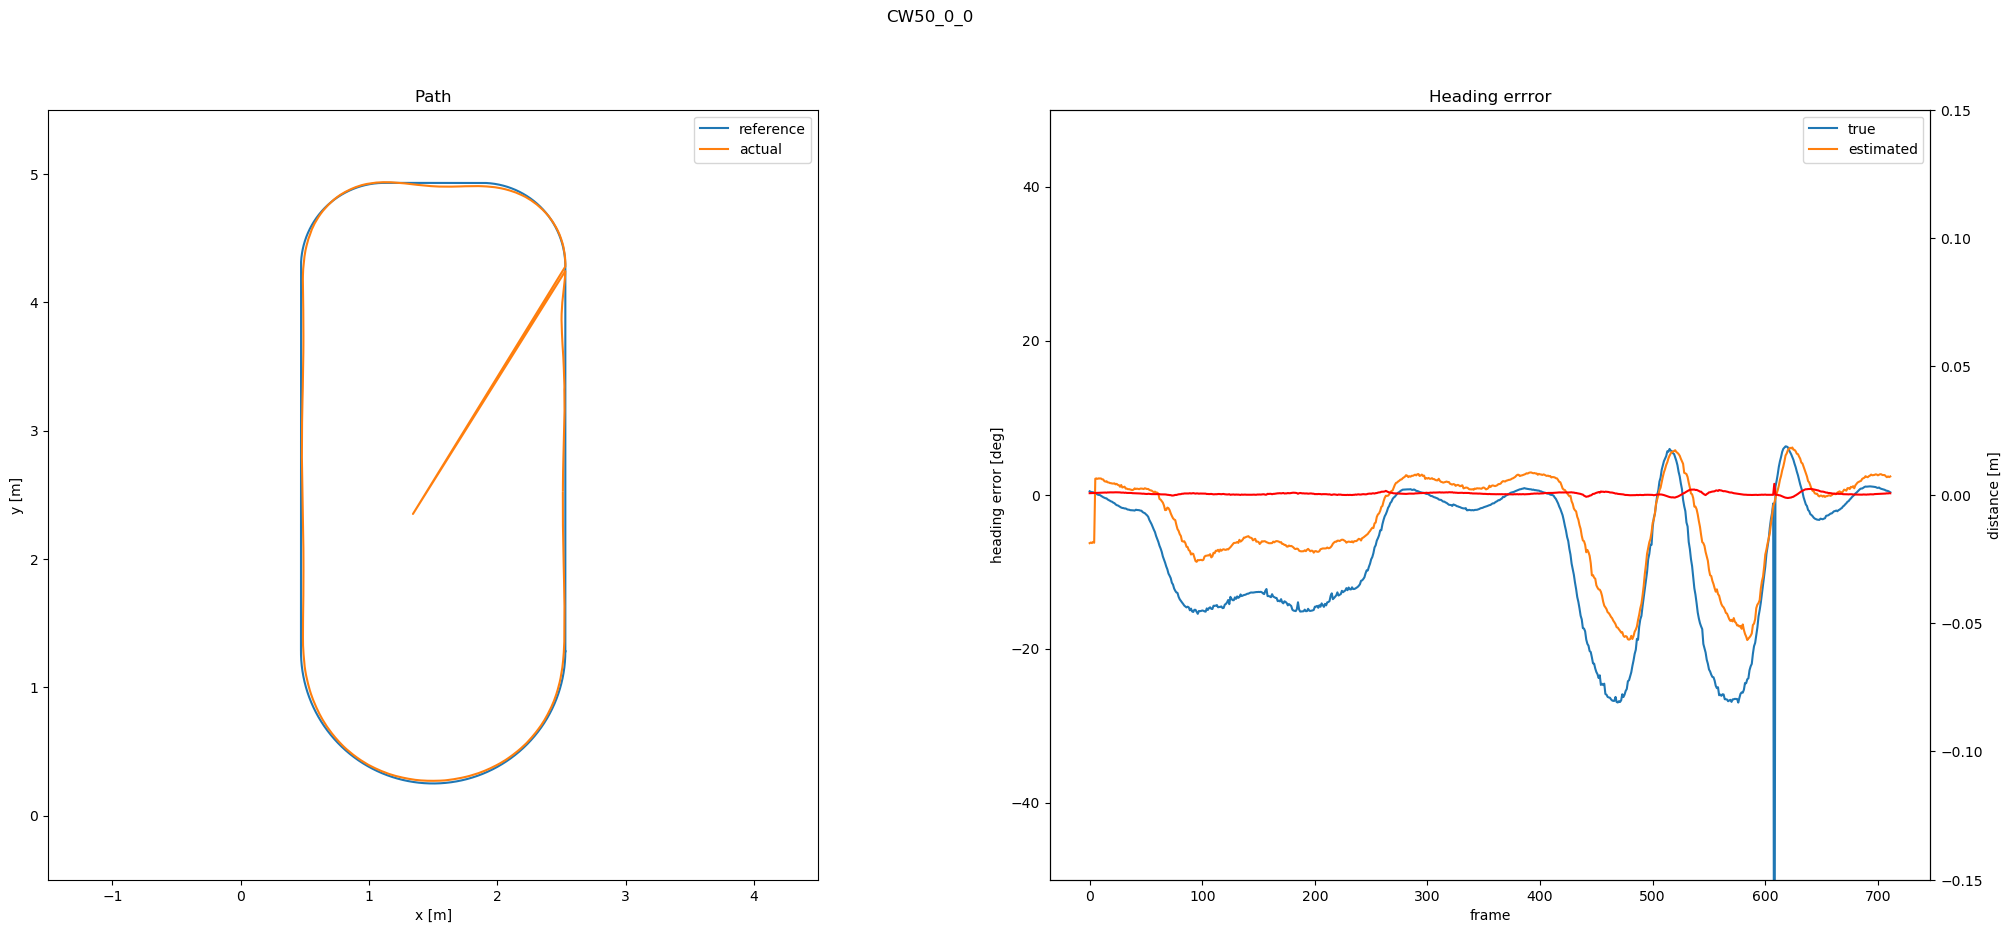

 
CW50_0_5
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


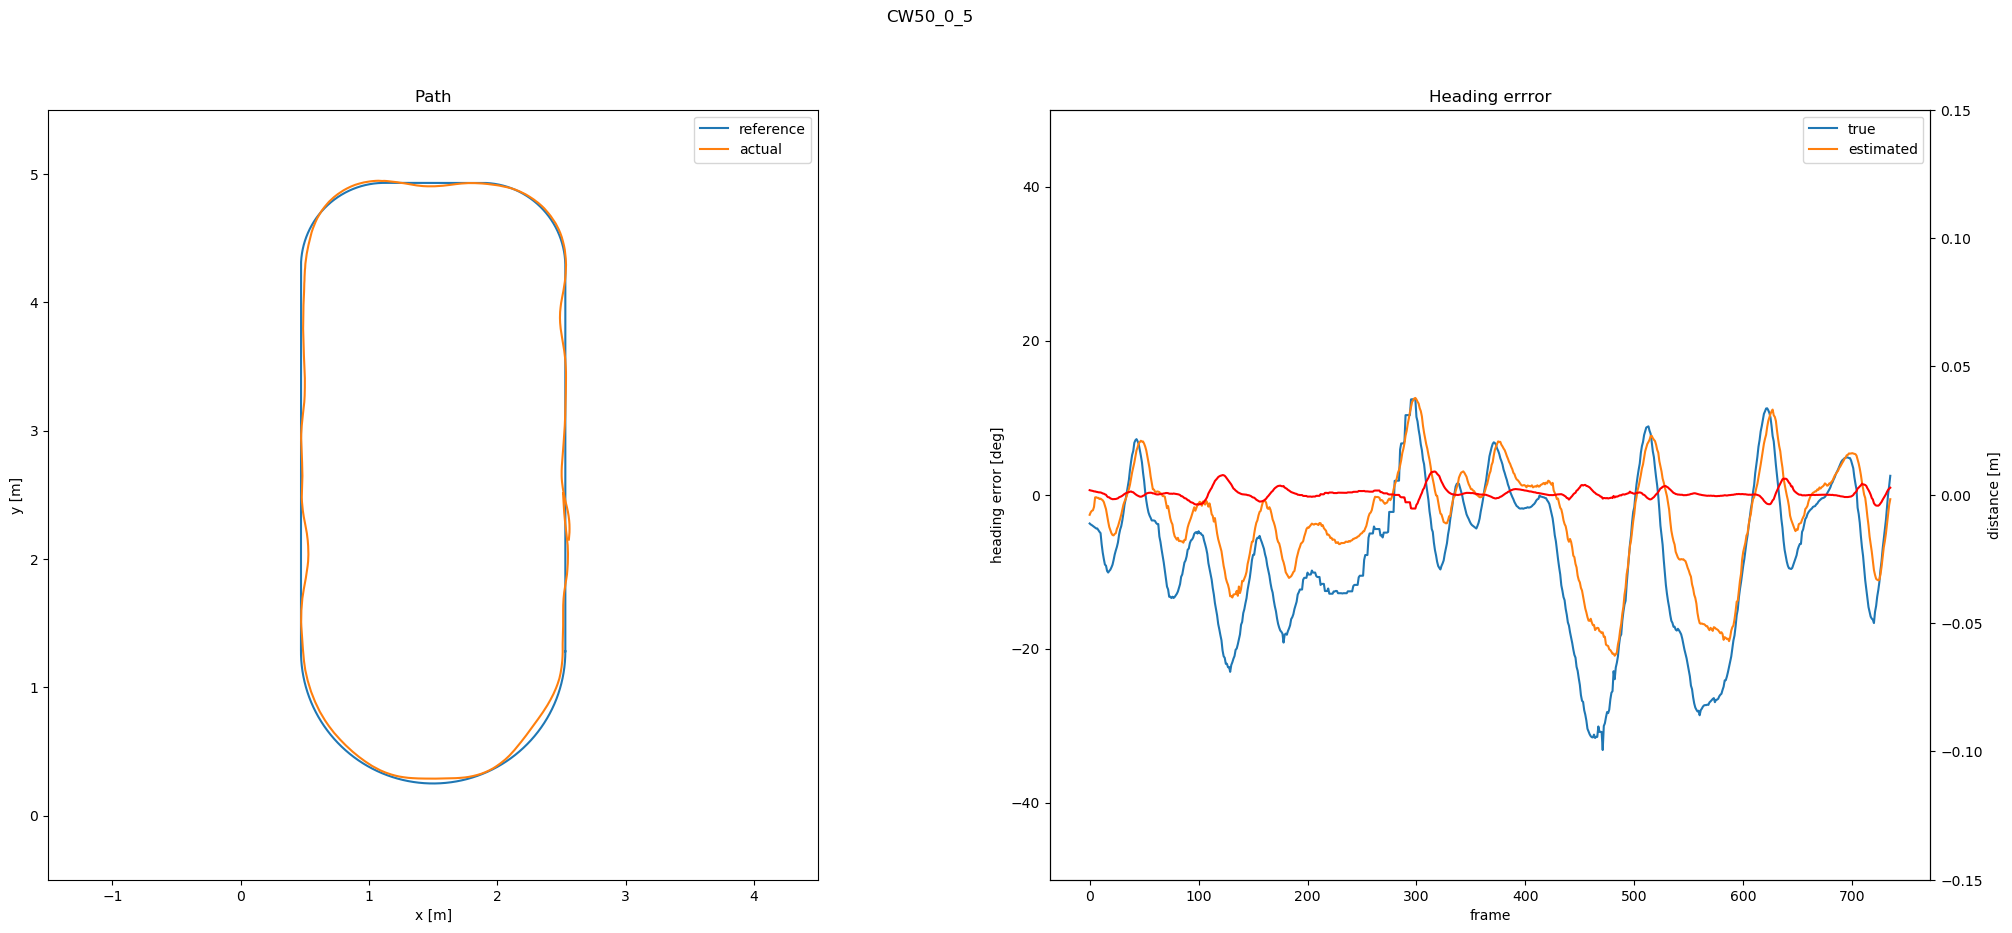

 
CW50_0_10
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


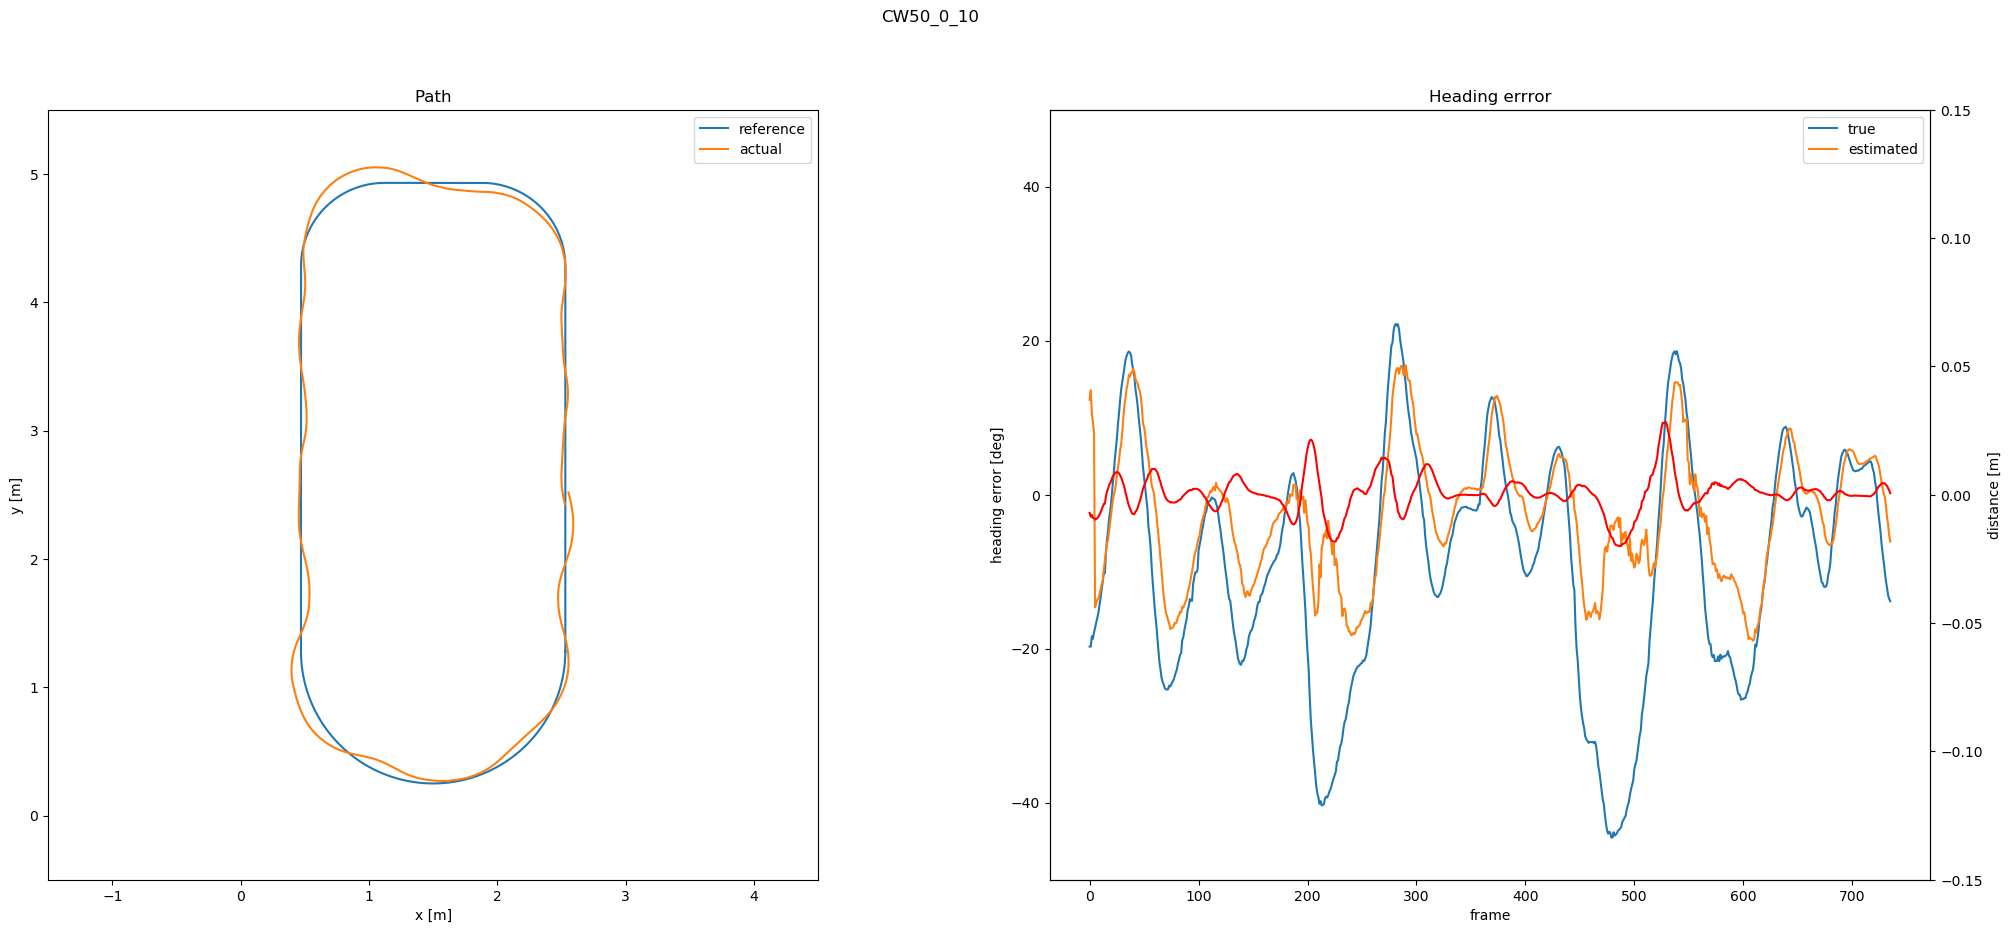

 
CW50_0_15
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


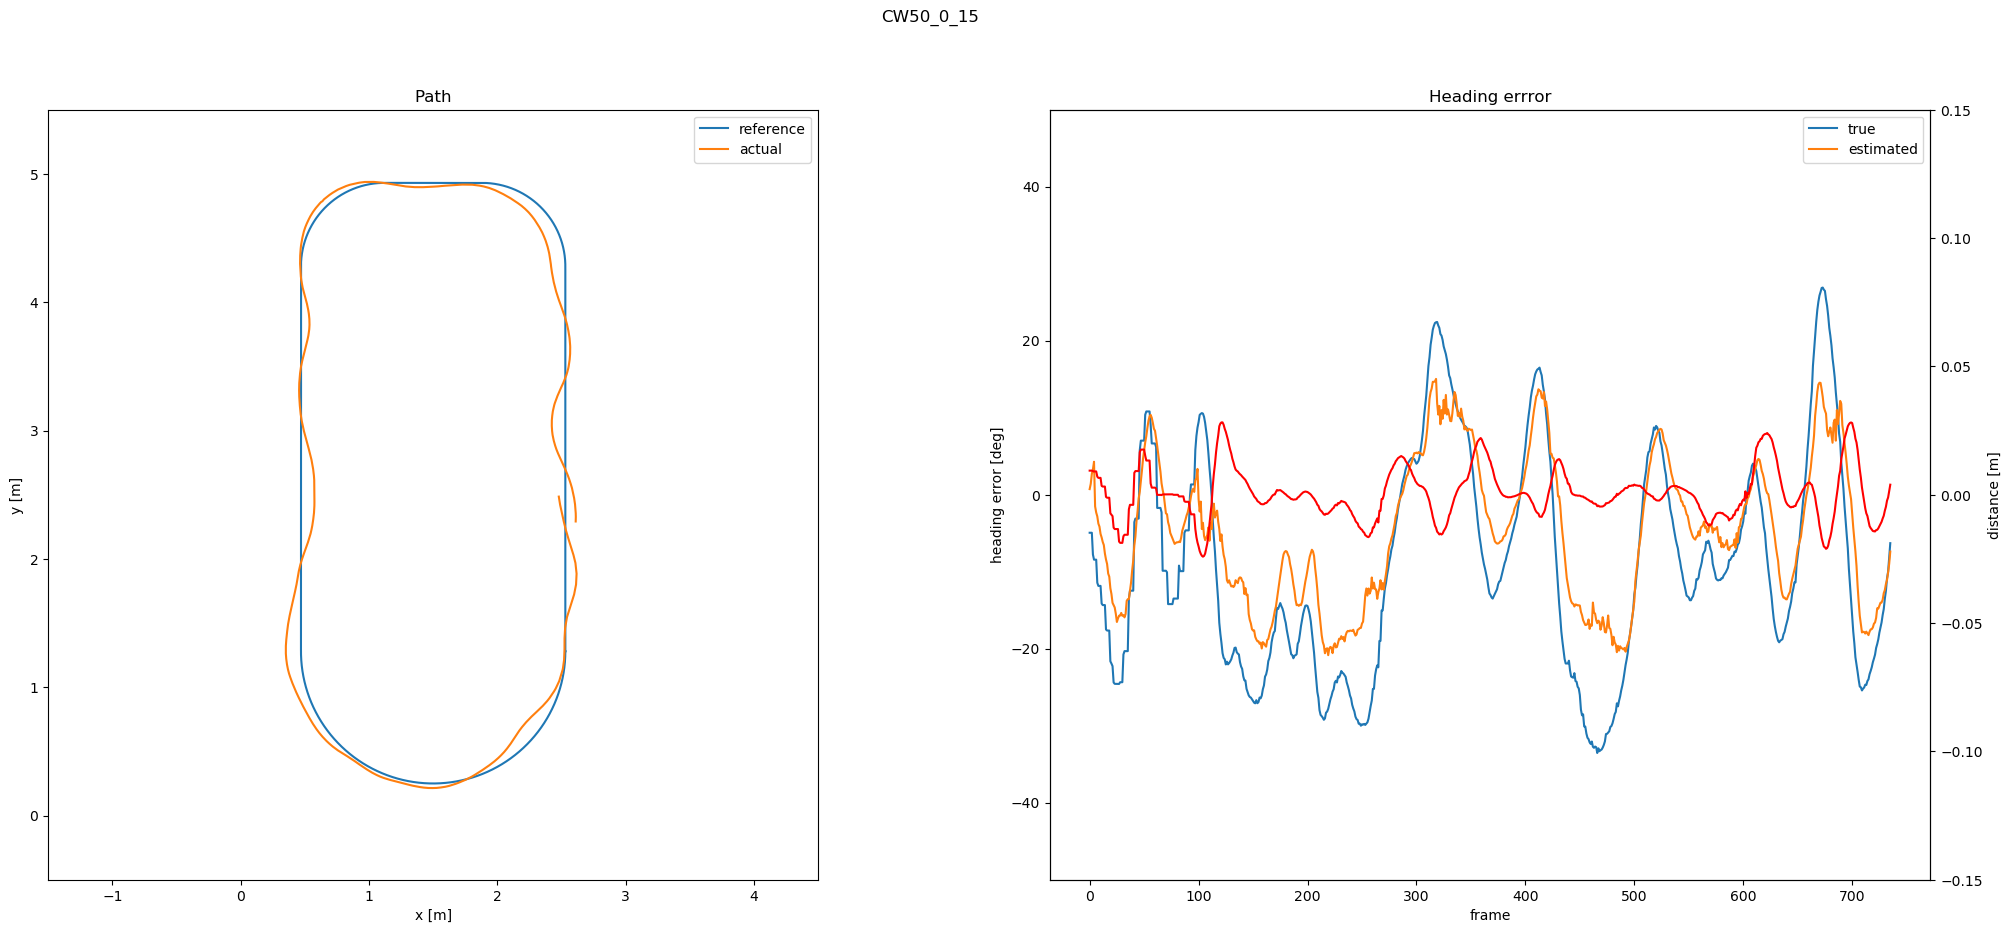

 
CW50_30_0
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


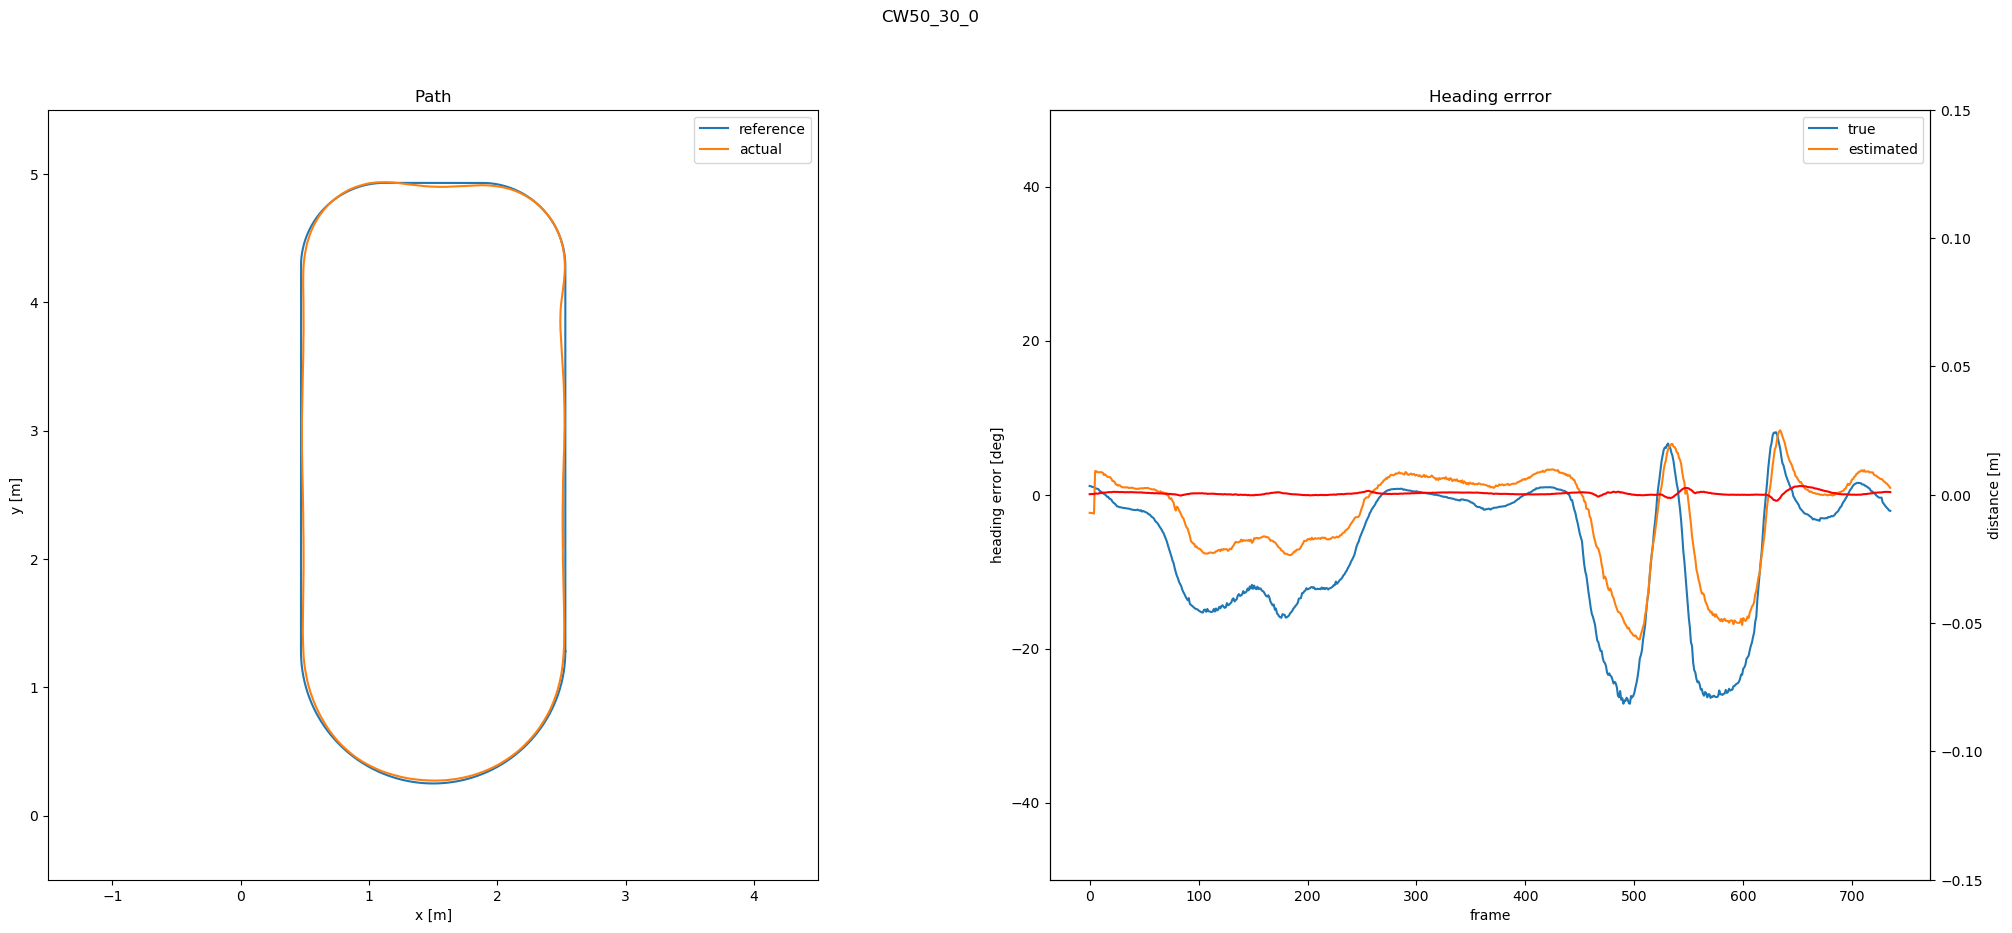

 
CW50_30_5
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


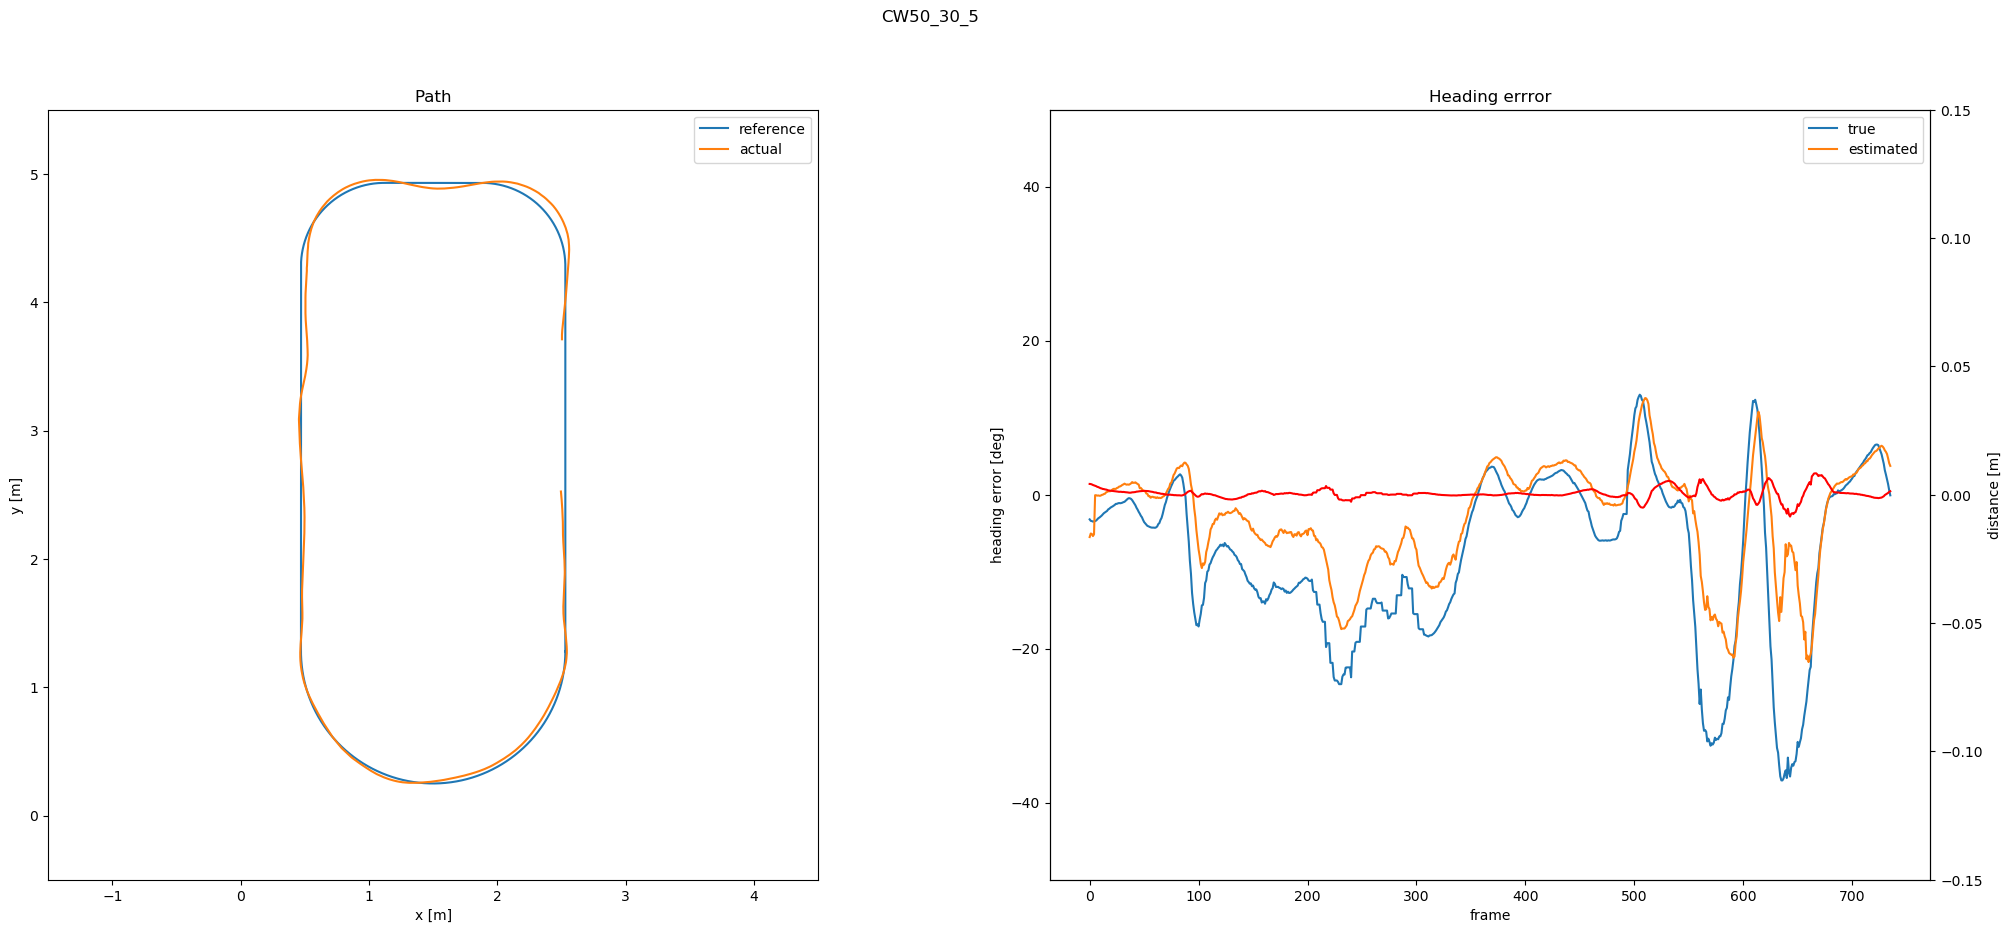

 
CW50_30_10
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


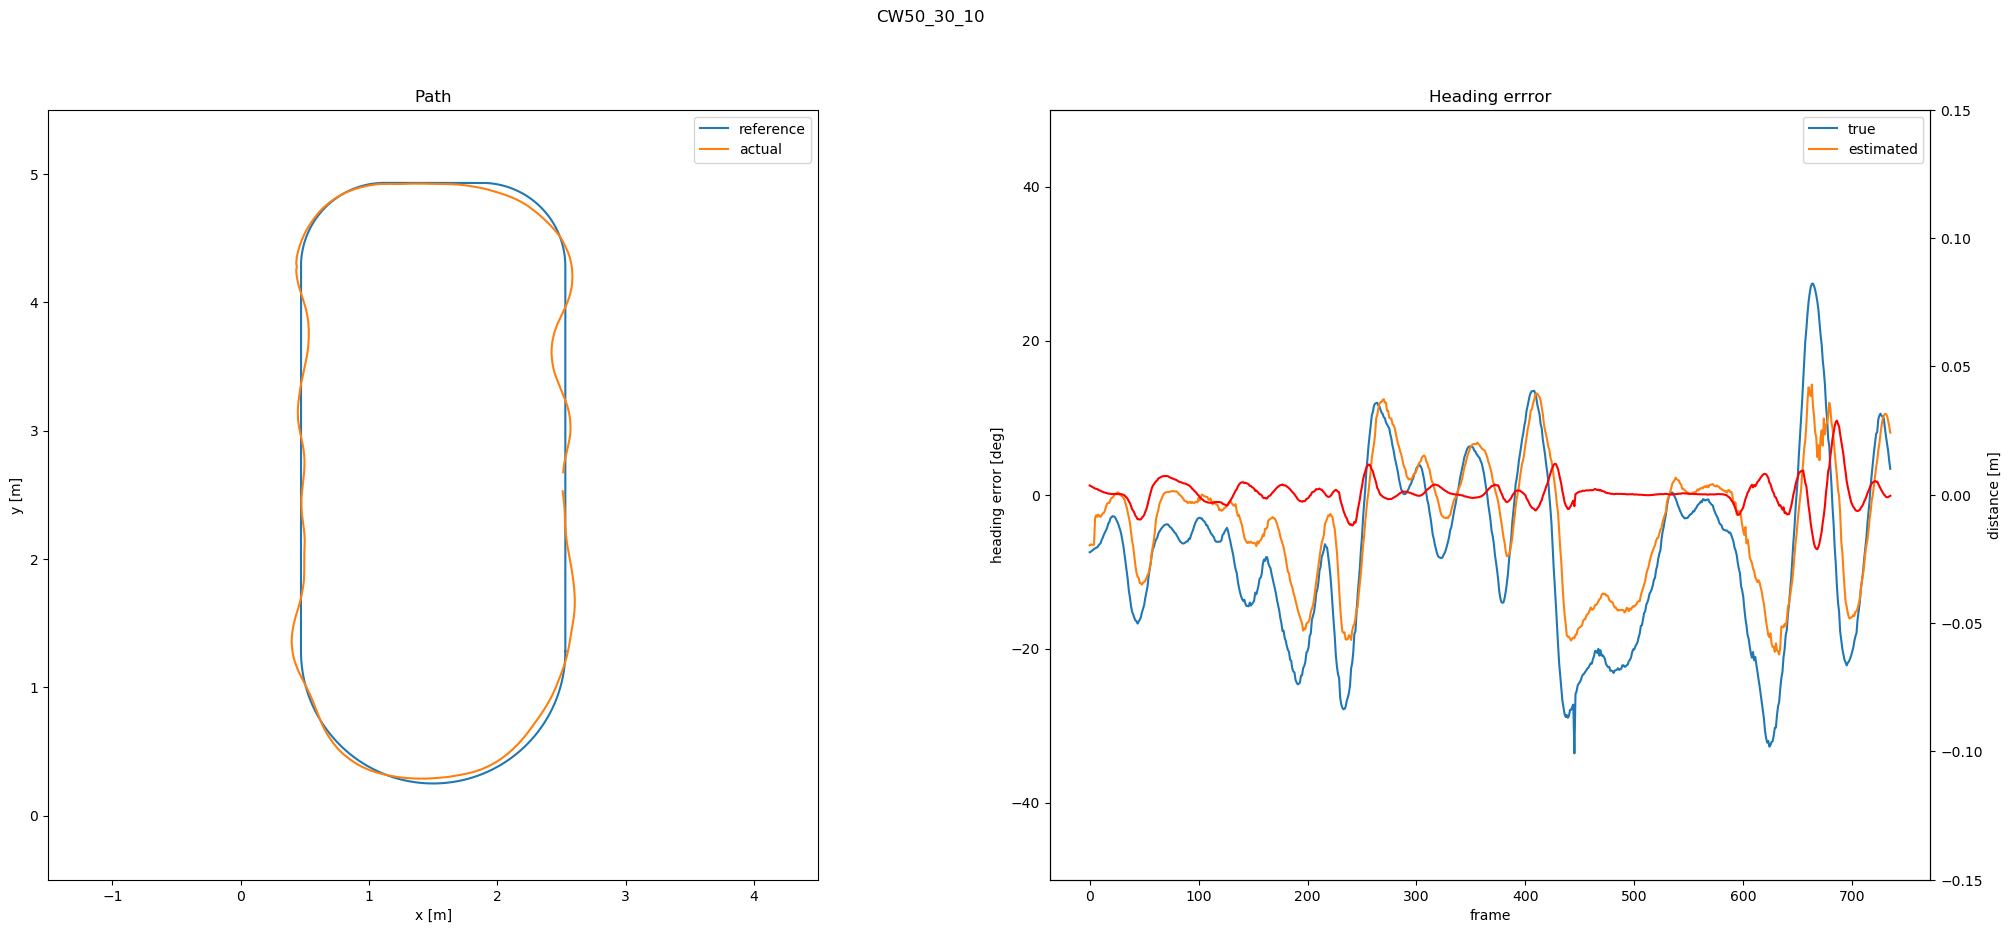

 
CW50_30_15
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


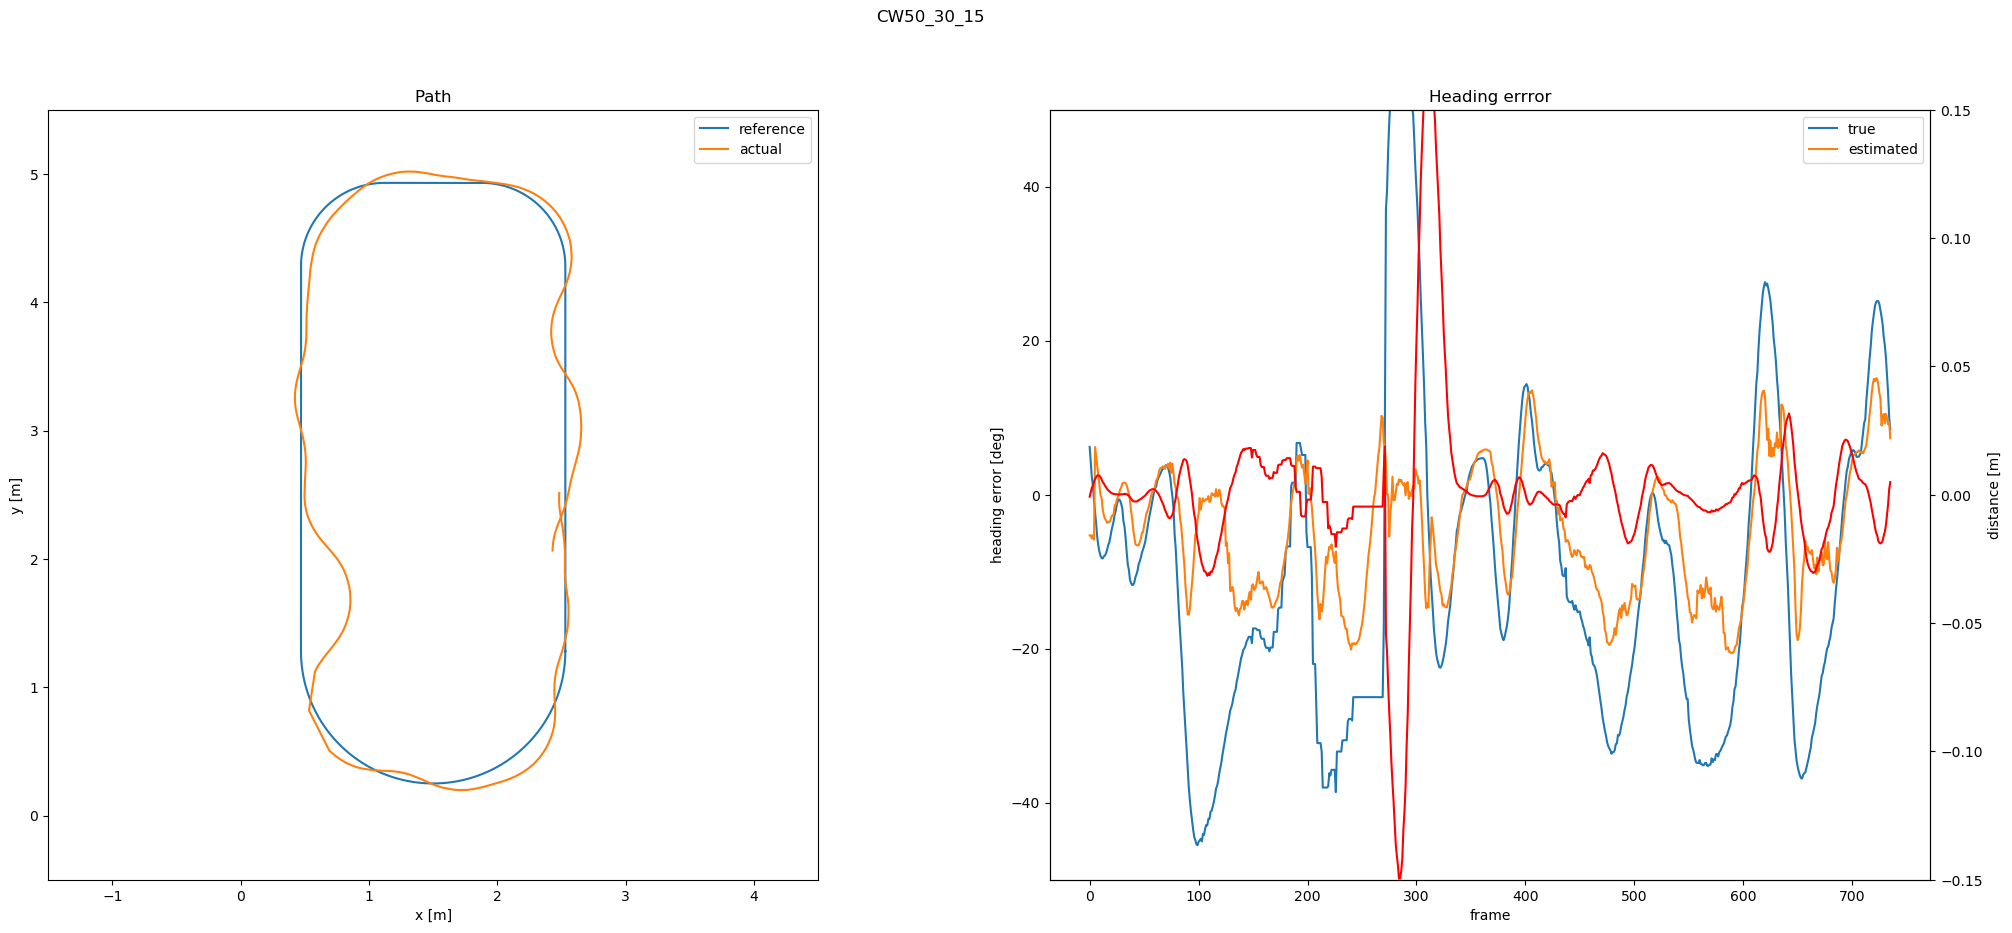

In [2]:
from cProfile import label
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from Simulator.src.helper_functions import *
from path_nn_controller import PathPlanning, Controller, Detection
from time import time, sleep
DIST_AHEAD = 0.5

NN = Detection() #initialize neural network

for name in names:
    print(name)
    log = np.load('saved_tests/'+name+'.npz')
    imgs, locs = log['imgs'],log['locs']
    #get ony the first lap
    imgs = imgs[:1473//2]
    locs = locs[:1473//2]
    path = np.load('sparcs_path_precise.npy').T
    print(f'frames: {len(imgs)}, locs: {len(locs)}')
    print(f'frame dim {imgs[0].shape}, locs dim {locs[0].shape}')

    #check if name starts with CW or ACW
    if name[:3] == 'ACW':
        path = np.flip(path, axis = 0) #if reversed/anti-clockwise

    hes = np.zeros(imgs.shape[0]) #heading error
    est_hes = np.zeros(imgs.shape[0]) #estimated heading error
    dists = np.zeros(imgs.shape[0]) #distances to path

    #calculations over all frames
    for i, (img, loc) in enumerate(zip(imgs, locs)):
        x = loc[0]
        y = loc[1]
        yaw = loc[2]
        img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)

        he, pa, d = get_heading_error(x,y,yaw,path, DIST_AHEAD)
        # sleep(10)
        est_he, est_pa = NN.estimate_he(img, distance_point_ahead=DIST_AHEAD)
        hes[i] = np.rad2deg(he)
        est_hes[i] = np.rad2deg(est_he)
        dists[i] = d

    ###############################################################
    # plotting, showing results

    #create matplotlib figure with 2 subplots
    fig, ax = plt.subplots(1,2, figsize=(25,10))
    fig.suptitle(name)
    ax[0].set_title('Path')
    ax[1].set_title('Heading errror')

    #plot path
    ax[0].plot(path[:,0], path[:,1], label='reference')
    ax[0].plot(locs[:,0], locs[:,1], label='actual')
    ax[0].set_aspect('equal')
    ax[0].legend()
    ax[0].set_xlabel('x [m]')
    ax[0].set_ylabel('y [m]')
    ax[0].set_xlim([1.5-3,1.5+3])
    ax[0].set_ylim([-.5,5.5])

    #plot heading errors
    ax[1].plot(hes, label='true')
    ax[1].plot(est_hes, label='estimated')
    ax[1].legend()
    ax[1].set_xlabel('frame')
    ax[1].set_ylabel('heading error [deg]')
    ax[1].set_ylim([-50,50])
    #create twinx
    ax2 = ax[1].twinx()
    ax2.plot(dists, '-r', label='dist ref path')
    # ax2.legend()
    ax2.set_ylabel('distance [m]')
    ax2.set_ylim([-0.15,0.15])
    plt.show(block=False)

    #show images
    cv.namedWindow(name, cv.WINDOW_NORMAL)
    cv.resizeWindow(name, 640, 480)
    for img, he, est_he in zip(imgs, hes, est_hes):
        img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)

        img = draw_angle(img, he, color=(200-50, 200-50, 100-50))
        img = draw_angle(img, est_he, color=(200-50, 100-50, 200-50))
        
        cv.imshow(name, img)
        k = cv.waitKey(1)
        if k == 27:
            break
        # sleep(0.008)
    cv.destroyAllWindows()
    print(' ')


